In [6]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
def show_img(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
z_dim = 64
image_dim = 28 * 28 * 1  # 784
num_epochs = 2

In [5]:
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST(root = "dataset/", train = True, transform = transforms, download = True)
train_loader = DataLoader(dataset= dataset, batch_size = batch_size, shuffle = True)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 128)
        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        ln1 = self.leakyrelu(self.linear(x,128))
        ln2 = self.linear(ln1,1)
        return self.sigmoid(ln2)

In [15]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, 256)
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.img_dim = img_dim

    def forward(self, z):
        ln1 = self.leakyrelu(self.linear(z,256))
        ln2 = self.linear(ln1, self.img_dim)
        return self.tanh(ln2)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(), 
        )
        
    def forward(self, x):
        return self.gen(x)

In [17]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

1875it [00:36, 52.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Gen 0.48447665572166443, Loss Disc 0.9525468349456787


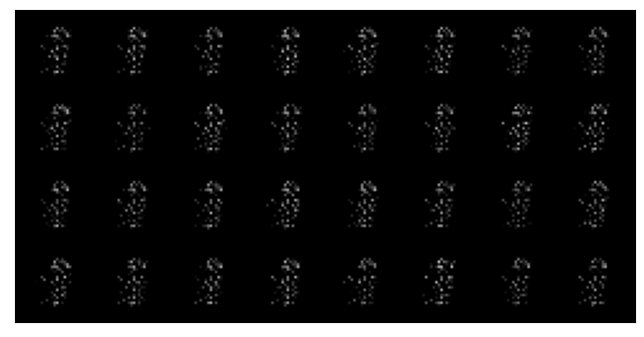

Epoch 1


1875it [00:33, 55.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


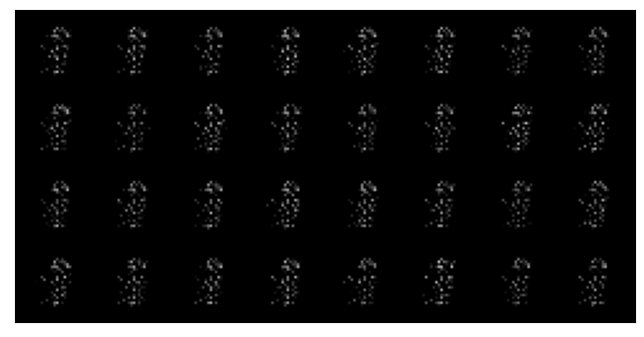

Epoch 2


1085it [00:17, 52.71it/s]

In [18]:
lossgen = []
lossdis = []
import matplotlib.pyplot as plt
from tqdm import tqdm
for epoch in range(100):
    for i, (real, _) in tqdm(enumerate(loader)):
        real = real.view(-1,784).to(device)
        batch_size = real.shape[0]
        
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
    if epoch % 5 == 0: 
        print (f"Loss Gen {lossG}, Loss Disc {lossD}")
        samples = fake.detach()
        z_samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    show_img(z_samples)
    print(f"Epoch {epoch + 1}")  
    lossgen.append(lossG)
    lossdis.append(lossD)

In [ ]:
lossesG= [ loss.detach().numpy() for loss in lossgen]
lossesD= [ loss.detach().numpy() for loss in lossdis]
plt.plot(lossesG)
plt.plot(lossesD)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['D_loss', 'G_loss'], loc='upper right')
plt.show()

In [ ]:
lossesG= [ loss.detach().numpy() for loss in lossgen]
lossesD= [ loss.detach().numpy() for loss in lossdis]
plt.plot(lossesG, label='G')
plt.plot(lossesD, label='D')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
noise = torch.randn(batch_size, z_dim).to(device)
fake = gen(noise)
print(fake.detach().numpy().shape)
plt.imshow(fake[1].detach().numpy().reshape(28,28), cmap = 'gray')

In [ ]:
samples = fake.detach()
samples = samples.view(samples.size(0), 1, 28, 28).cpu()
show_img(samples)  